# pedigreeGroupUnrelated


*Juan Carlos Valverde-Hernández*
jcvalverdehernandez@gmail.com --- **2021**

This tool generates a list of genetically unrelated individuals from a PED file. For validation, it outputs a pedigree plot that distinguishes the individuals in the unrelated group from the ones that were selected.

This application can be useful for population genetics and genomics studies. In cases where allelic frequencies want to be estimated for a genetically unrelated population, but the available data sources include related individuals, this script may help to filter related individuals while maximizing the sample size.


## 1. Libraries



- `pandas` library is imported to manage dataframes
- `randint` is imported from library `random` to randomly select individuals in cases where only one individual may be selected from a set of individuals.
- `graphviz` library is used to graph the pedigree file being analized. It helps to visualize which unrelated individuals where selected.

In [1]:
import pandas as pd
from random import randint
import graphviz
from graphviz import Graph


##  2. Define functions

### 2. a. Grouping the unrelated individuals in one dataset

The `less_related` function groups the individuals with no registered ascendants in the group asc_none and the individuals with one ascendant in the group asc_one.

In [2]:
def less_related(PED):
    """
    Groups the individuals with no registered ascendants in the group asc_none and the individuals with
    one ascendant in the group asc_one.

    Args:
      minimum:
          PED: A PED file is required. The column name of the data corresponding to the family ID must be
          'famid', likewise the individual ID must be 'id', father ID must be set as 'fid', mother ID as 'mid' and sex
          as 'sex'.
    Returns:
      A dictionary that has as index each family ID. Each dictionary entry contains a dictionary with the asc_none group
      and the asc_one group. asc_none is a list and asc_one is a dictionary that contains a list of the ascendants for every
      individual with one valid ascendant.
    """
    
    database = {}

    for i in range(0, len(PED)):
        if PED.iloc[i]["fid"] == 0 and PED.iloc[i]["mid"] == 0:
            try:

                database[PED.iloc[i]["famid"]]["asc_none"].append(PED.iloc[i]["id"])
            except:
                database[PED.iloc[i]["famid"]] = {"asc_none" : [PED.iloc[i]["id"]]}

        if (PED.iloc[i]["fid"] != 0 and PED.iloc[i]["mid"] == 0) or (PED.iloc[i]["fid"] == 0 and PED.iloc[i]["mid"] != 0):

            try:

                database[PED.iloc[i]["famid"]]["asc_one"][PED.iloc[i]["id"]] = [PED.iloc[i]["fid"], PED.iloc[i]["mid"]]


            except:
                database[PED.iloc[i]["famid"]]["asc_one"] = {PED.iloc[i]["id"]: [PED.iloc[i]["fid"], PED.iloc[i]["mid"]]}

    return(database)

The `redundants` function that Identifies groups of related individuals that can only be included interchangeably in the final dataset. This is required in cases where various individuals in one lineage where individuals have only one registered ascendant, and the final ascendant has no registered ascendants.

In [3]:
def redundants(lessRelatedDatabase, family, individual):
    
    """
    Identifies groups of related individuals that can only be included interchangeably in the final dataset. This is 
    required in cases where various individuals in one lineage where individuals have only one registered ascendant, and the
    final ascendant has no registered ascendants.

    Args:
      minimum:
          lessRelatedDatabase: The output of the less_related function.
          family: a valid family ID.
          individual: a valid individual with only one valid ascendant.
    Returns:
      A list of individuals that are genetically related and that only one of them may be included in the final dataset.
    """
       
    redundancies = []

    father, mother = lessRelatedDatabase[family]["asc_one"][individual][0], lessRelatedDatabase[family]["asc_one"][individual][1]
    for direct_asc in [father, mother]:
        if direct_asc in lessRelatedDatabase[family]["asc_one"]:

            if direct_asc == 0:
                pass
            else:
                for ascendant in redundants(lessRelatedDatabase, family, direct_asc):
                    redundancies.append(ascendant)
        if direct_asc in lessRelatedDatabase[family]["asc_none"]:

            if direct_asc == 0:
                pass
            else:
                redundancies.append(direct_asc)

    redundancies.append(individual)

    return(redundancies)
    


The `select_participants` outputs the largest group of unrelated individuals possible based on the data provided by the PED file. An individual is randomly selected for each `redundants` function output.

In [4]:
def select_participants(lessRelatedDatabase):
    
    """
    Outputs the largest group of unrelated individuals possible based on the data provided by the PED file.
    
    Args:
      minimum:
          lessRelatedDatabase: The output of the less_related function.
    Returns:
      Returns a dictionary which contains as keys, the family ID. Each of this entries contains a list of unrelated
      individuals.
    """
    
    
    
    proposed_participants_ls = {}
    for family in lessRelatedDatabase:
        proposed_participants_ls[family] = []
        for asc_one_id in lessRelatedDatabase[family]["asc_one"]:

            monoparental_lineage = redundants(lessRelatedDatabase, family, asc_one_id)

            if len(proposed_participants_ls[family])!=0:
                counter = 0
                for added_redundants in proposed_participants_ls[family]:
                    
                    lineage_len = len(monoparental_lineage)
                    add_check = False
                    replace_check = False
                    if type(added_redundants)==int:
                        if added_redundants in monoparental_lineage:
                            replace_check = True
                        replace_check = 1
                    elif type(added_redundants)==list:
                        for added_redundants_parsed in added_redundants:
                            if added_redundants_parsed in monoparental_lineage:
                                if len(monoparental_lineage) > len(added_redundants):
                                    replace_check = True
                    if replace_check:
                        proposed_participants_ls[family][counter] = monoparental_lineage
                    counter += 1
                        

            else:
                add_check = True
            
            if add_check:
                if len(monoparental_lineage) == 1:
                    proposed_participants_ls[family].append(monoparental_lineage[0])
                elif len(monoparental_lineage) > 1:
                    proposed_participants_ls[family].append(monoparental_lineage)

                
        non_redundants = []
        for asc_none_id in lessRelatedDatabase[family]["asc_none"]:
            for registered_redundants in proposed_participants_ls[family]:
                if asc_none_id in registered_redundants:
                    pass
                else:
                    non_redundants.append(asc_none_id)   
                    
        proposed_participants_ls[family] = proposed_participants_ls[family] + non_redundants 
         
            
        #Selecting randomly one individual per redundant lineage
        counter = 0
        for participant in proposed_participants_ls[family]:
            if type(participant) == list:
                random_lineage_participant = randint(1, len(participant))
                proposed_participants_ls[family][counter] = participant[random_lineage_participant - 1]
            counter += 1
            
    return(proposed_participants_ls)
        


With the `ped_annotate_selected` function, the PED file is annotated with the selection status for each individual. A value of 2 indicates that the individual was  ncluded in the unrelated selected individual group, a value of 0 indicates otherwise. The PED file is exported
      as pedigree_selection.ped to the working directory.

In [5]:
def ped_annotate_selected(PED, proposed_participants):
    
    """
    The PED file is annotated with the selection status for each individual. A value of 2 indicates that the individual was
    included in the unrelated selected individual group, a value of 0 indicates otherwise. 
    
    Args:
      minimum:
          PED: A PED file is required. The column name of the data corresponding to the family ID must be
          'famid', likewise the individual ID must be 'id', father ID must be set as 'fid', mother ID as 'mid' and sex
          as 'sex'.
          proposed_participants: The output of the select_participants function. A dictionary which contains as keys, the
          family ID. Each of this entries contains a list of unrelated individuals.
    Returns:
      The PED file with an added column named "selection_status" which indicates if individuals where selected
      using the value 2. If the individuals were not selected, the selection_status was set to 0. The PED file is exported
      as pedigree_selection.ped to the working directory.

    """
    
    selected_status_ls = []
    for i in range(0, len(PED)):

        if PED.iloc[i]["id"] in proposed_participants[PED.iloc[i]["famid"]]:
            
            selected_status_ls.append(2)
        else:
            selected_status_ls.append(0)
            
    PED["selection_status"] = selected_status_ls
    PED.to_csv('pedigree_selection.ped', sep = '\t', index = False)
    return PED


### 2. b. Visualize 


To enable pedigree visualization using graphviz, individuals are characterized with the`individual_profile` function. Each individual is annotated with the following information: descendants, siblings, ascendants, partners, sex, classifier and generation.

In [6]:
def individual_profile (filteredPED):
    
    """
    To enable pedigree visualization using graphviz, individuals are characterized. Each individual is annotated with
    the following information: descendants, siblings, ascendants, partners, sex, classifier and generation
    
    Args:
      minimum:
          filteredPED: A PED file is required. The column name of the data corresponding to the family ID must be
          'famid', likewise the individual ID must be 'id', father ID must be set as 'fid', mother ID as 'mid' and sex
          as 'sex'. selection_status is set as classifier but it could be interchange to codition for example. It only allows
          a PED file with only one family ID.
          proposed_participants: The output of the select_participants function. A dictionary which contains as keys, the
          family ID. Each of this entries contains a list of unrelated individuals.
    Returns:
        A dictionary which contains as entries, the individuals included. Each individual is labeled with the 
        descendants, siblings, ascendants, partners, sex, classifier and generation variables.

    """    
    

    individualProfileDatabase = {}

    for i in range(0, len(filteredPED)):

        currentID = filteredPED["id"][i]
        generation = 0
        ascendants = []
        descendants = set()
        partners = set()
        siblings = set()


        for e in [filteredPED["fid"][i], filteredPED["mid"][i]]:
            if e == 0:
                pass
            else:
                if e == currentID:
                    pass
                else:   
                    ascendants.append(e)   

        if filteredPED["sex"][i] == 2:
            for e in (filteredPED[filteredPED["mid"] == filteredPED["id"][i]]["id"]):
                if e == currentID:
                    pass
                else:
                    descendants.add(e)
            for e in (filteredPED[filteredPED["mid"] == filteredPED["id"][i]]["fid"]):
                if e != 0:
                    if e == currentID:
                        pass
                    else:
                        partners.add(e)

        elif filteredPED["sex"][i] == 1:

            for e in (filteredPED[filteredPED["fid"] == filteredPED["id"][i]]["id"]):
                if e == currentID:
                    pass
                else:
                    descendants.add(e)
            for e in (filteredPED[filteredPED["fid"] == filteredPED["id"][i]]["mid"]):
                if e != 0:
                    if e == currentID:
                        pass
                    else:
                        partners.add(e)
        else:
            print("Unexpected input.")

        #siblings, mother
        if filteredPED["mid"][i] == 0:
            pass
        else: 
            for e in (filteredPED[filteredPED["mid"] == filteredPED["mid"][i]]["id"]): #este filtado esta mal hecho
                if e == currentID:
                    pass
                else:
                    siblings.add(e)

        #siblings, father
        if filteredPED["fid"][i] == 0:
            pass
        else:  
            for e in (filteredPED[filteredPED["fid"] == filteredPED["fid"][i]]["id"]):
                if e == currentID:
                    pass
                else:
                    siblings.add(e)
        individualProfileDatabase[filteredPED["id"][i]]  = {"descendants": descendants}
        individualProfileDatabase[filteredPED["id"][i]]["siblings"]  = siblings

        individualProfileDatabase[filteredPED["id"][i]]["ascendants"]  = ascendants
        individualProfileDatabase[filteredPED["id"][i]]["partners"]  = partners
        individualProfileDatabase[filteredPED["id"][i]]["sex"]  = filteredPED["sex"][i]
        individualProfileDatabase[filteredPED["id"][i]]["classifier"]  = filteredPED["selection_status"][i]

        individualProfileDatabase[filteredPED["id"][i]]["generation"]  = [0, 0]


    counter = 0

    for i in individualProfileDatabase:
        if counter == 0:
            inicial = i
        link = ""
        if individualProfileDatabase[i]["generation"][1] == 0:

            for e in individualProfileDatabase[i]["descendants"]:
                if individualProfileDatabase[e]["generation"][1] == 1:
                    individualProfileDatabase[i]["generation"] = [individualProfileDatabase[e]["generation"][0] - 1, 1]
                    link = "found"

            for e in individualProfileDatabase[i]["ascendants"]:
                if individualProfileDatabase[e]["generation"][1] == 1:
                    individualProfileDatabase[i]["generation"] = [individualProfileDatabase[e]["generation"][0] + 1, 1]
                    link = "found"

            for e in individualProfileDatabase[i]["siblings"]:
                if individualProfileDatabase[e]["generation"][1] == 1:
                    individualProfileDatabase[i]["generation"] = [individualProfileDatabase[e]["generation"][0], 1] 
                    link = "found"

            for e in individualProfileDatabase[i]["partners"]:
                if individualProfileDatabase[e]["generation"][1] == 1:
                    individualProfileDatabase[i]["generation"] = [individualProfileDatabase[e]["generation"][0], 1] 
                    link = "found"

        else:
            pass
        if link == "":
                try:
                    for descendant in individualProfileDatabase[i]["descendants"]:
                        individualProfileDatabase[descendant]["generation"] = [individualProfileDatabase[i]["generation"][0] + 1, 1]
                except:
                    pass
                try:
                    for ascendant in individualProfileDatabase[i]["ascendants"]:
                        individualProfileDatabase[ascendant]["generation"] = [individualProfileDatabase[i]["generation"][0] - 1, 1]
                except:
                    pass
                try:
                    for sibling in individualProfileDatabase[i]["siblings"]:
                        individualProfileDatabase[sibling]["generation"] = [individualProfileDatabase[i]["generation"][0], 1]  
                except:
                    pass
                try:
                    for partner in individualProfileDatabase[i]["partners"]:
                        individualProfileDatabase[partner]["generation"] = [individualProfileDatabase[i]["generation"][0], 1]  
                except:
                    pass
        counter += 1

    for e in individualProfileDatabase[inicial]["descendants"]:
        if individualProfileDatabase[e]["generation"][1] == 1:
            individualProfileDatabase[inicial]["generation"] = [individualProfileDatabase[e]["generation"][0] - 1, 1]

    for e in individualProfileDatabase[inicial]["ascendants"]:
        if individualProfileDatabase[e]["generation"][1] == 1:
            individualProfileDatabase[inicial]["generation"] = [individualProfileDatabase[e]["generation"][0] - 1, 1]                

    for e in individualProfileDatabase[inicial]["siblings"]:
        if individualProfileDatabase[e]["generation"][1] == 1:
            individualProfileDatabase[inicial]["generation"] = [individualProfileDatabase[e]["generation"][0], 1] 



    return(individualProfileDatabase)

To enable pedigree visualization using graphviz, the function `gen_stratification` generates node information from the data outputed by the individual_profile function.

In [7]:
def gen_stratification(individualProfileDatabase):
    """
    To enable pedigree visualization using graphviz, node information is generated from the data outputed by the
    individual_profile function.
    
    Args:
      minimum:
          individualProfileDatabase: The output of tbe individual_profile function. A dictionary which 
          contains as entries, the individuals included. Each individual is labeled with the descendants, 
          siblings, ascendants, partners, sex, classifier and generation variables.
          
    Returns:
        genNodes: information required to build nodes each generation.  
        descNode: information required to build nodes that link the descendants with the ascendants.
    """    
    pedGen = set()
    for i in individualProfileDatabase:
        pedGen.add(individualProfileDatabase[i]["generation"][0])

    genNodes = {}
    descNode = {}

    for i in range(min(pedGen), max(pedGen) + 1):
        genNodes[i] = []
        descNode[i + 0.5] = []
        for e in individualProfileDatabase:
            if individualProfileDatabase[e]["generation"][0] == i:

                genNodes[i].append([str(e), individualProfileDatabase[e]["sex"], individualProfileDatabase[e]["classifier"]])

                partners = individualProfileDatabase[e]["partners"]

                if len(individualProfileDatabase[e]["partners"]) != 0:
                    for partner in individualProfileDatabase[e]["partners"]:

                        if ([partner, e] in genNodes[i]) or ([e, partner] in genNodes[i]) :
                            pass
                        else:
                            genNodes[i].append([partner, e])
                            if len(individualProfileDatabase[e]["descendants"]) != 0:
                                descNode[i + 0.5].append([partner, e])

                else:
                    if len(individualProfileDatabase[e]["descendants"]) != 0:
                        descNode[i + 0.5].append(e)

    return(genNodes, descNode)
                    

With the function  `graph_pedigree`, the pedigrees are graphed using graphviz library, interface for DOT engine. Diferenciates by colour the individuals acording to its classifier status.

In [8]:
def graph_pedigree(individualProfileDatabase, family, genNodes, descNode):
    """
    The pedigree is graphed using graphviz library, interface for DOT engine. Diferenciates by colour the 
    individuals acording to its classifier status.
    
    Args:
      minimum:
          individualProfileDatabase: The output of tbe individual_profile function. A dictionary which 
          contains as entries, the individuals included. Each individual is labeled with the descendants, 
          siblings, ascendants, partners, sex, classifier and generation variables.
          family: The family to being graphed.
          genNodes: information required to build nodes each generation. Generated with the gen_stratification function.
          descNode: information required to build nodes that link the descendants with the ascendants. Generated with 
          the gen_stratification function.
          
    Returns:
          Exports pedigree graph, diferenciates by colour the individuals acording to its classifier status.
    """    
    
    pedGen = set()
    for i in individualProfileDatabase:
        pedGen.add(individualProfileDatabase[i]["generation"][0])
    
    dot = Graph(engine='DOT', comment="ped_", graph_attr = {'splines':'ortho', 'concentrate': 'true'}, strict = True)    

    for i in range(min(pedGen), max(pedGen) + 1):
        with dot.subgraph(name = str(i)) as subs:
            subs.attr(rank = 'same')
            for e in genNodes[i]:

                #set format                  
                if (len(e) == 3):
                    if e[1] == 1:
                        shape = "rect"
                    else:
                        shape = "ellipse"      
                    if e[2] == 2:
                        color = "green"
                    else:
                        color = "red" 
                    subs.node(e[0], shape = shape, style='filled', color = color)
                else:
                    nodeName = str(e[0]) + "_" + str(e[1])
                    subs.node(nodeName, shape = "point")
                    subs.edge(str(e[0]), nodeName)
                    subs.edge(nodeName, str(e[1]))
        with dot.subgraph(name = str(i + 0.5)) as subs:

            for e in descNode[i + 0.5]:
                if i == (max(pedGen)):
                    
                    pass
                else:
                    if type(e) == list:
                        nodeName = str(e[0]) + "_" + str(e[1])
                        intergenNodeName = nodeName + "_desc"
                        subs.node(intergenNodeName , shape = "point")
                        subs.edge(nodeName, intergenNodeName)
                    else:
                        nodeName = str(e)
                        intergenNodeName = nodeName + "_desc"
                        subs.node(intergenNodeName , shape = "point")
                        subs.edge(nodeName, intergenNodeName)
        if i == min(pedGen):
            pass
        else:
            for e in genNodes[i]:
                if type(e[0]) == str:
                    e = int(e[0])
                    ascendants = individualProfileDatabase[e]["ascendants"]
                    if len(ascendants) == 1:
                        if len(individualProfileDatabase[ascendants[0]]["descendants"]) != 1:
                            intergenNodeName = str(ascendants[0]) + "_desc"
                            dot.node(intergenNodeName , shape = "point")
                            dot.edge(str(ascendants[0]), intergenNodeName)
                            dot.edge(intergenNodeName, str(e))
                        else:
                            intergenNodeName = str(ascendants[0]) + "_desc"
                            dot.edge(intergenNodeName, str(e))
                    elif len(ascendants) == 2:
                        if (ascendants in genNodes[i - 1]):
                            intergenNodeName = str(ascendants[0]) + "_" + str(ascendants[1]) + "_desc"
                            dot.edge(intergenNodeName, str(e))
                        elif ([ascendants[1], ascendants[0]] in genNodes[i - 1]):
                            intergenNodeName = str(ascendants[1]) + "_" + str(ascendants[0]) + "_desc"
                            dot.edge(intergenNodeName, str(e))
                        else:
                            print("Unexpected input.")
                    else:
                        pass
                else:
                    pass

    dot.node("Family ID: " + str(family), shape = "box")
    dot.format = 'svg'
    dot.render('pedigree_family_' + str(family) + '.gv', view = True)
          

## 3. Data processing and analysis

PED dataset is imported.

In [9]:
PED = pd.read_csv("test_pedigree.ped", sep='\t')
PED

,famid,id,fid,mid,sex,aff
0,1,2,0,0,2,1
1,1,3,0,2,1,1
2,1,8,0,0,1,1
3,1,10,0,0,1,1
4,1,11,0,0,2,1
5,1,9,10,11,2,1
6,1,4,8,9,2,1
7,1,5,3,4,2,1
8,1,6,3,4,2,1
9,1,7,3,4,2,1


Selecting unrelated individuals.

In [10]:
lessRelatedDatabase = less_related(PED)
lessRelatedDatabase

{1: {'asc_none': [2, 8, 10, 11, 12, 15], 'asc_one': {3: [0, 2]}},
 2: {'asc_none': [12, 13, 14, 15, 8, 9, 10, 20, 22], 'asc_one': {7: [10, 0]}},
 3: {'asc_none': [1, 2, 4, 12, 13, 8, 10],
  'asc_one': {15: [0, 13], 17: [0, 15]}}}

In [11]:
proposed_participants = select_participants(lessRelatedDatabase)
proposed_participants

{1: [2, 8, 10, 11, 12, 15],
 2: [7, 12, 13, 14, 15, 8, 9, 20, 22],
 3: [13, 1, 2, 4, 12, 8, 10]}

In [12]:
annotatedPED = ped_annotate_selected(PED, proposed_participants)
annotatedPED

,famid,id,fid,mid,sex,aff,selection_status
0,1,2,0,0,2,1,2
1,1,3,0,2,1,1,0
2,1,8,0,0,1,1,2
3,1,10,0,0,1,1,2
4,1,11,0,0,2,1,2
5,1,9,10,11,2,1,0
6,1,4,8,9,2,1,0
7,1,5,3,4,2,1,0
8,1,6,3,4,2,1,0
9,1,7,3,4,2,1,0


Pedigree plots are generated.

In [13]:
for family in set(annotatedPED["famid"]):
    filteredPED = annotatedPED[annotatedPED["famid"] == family].copy().reset_index()
    individualProfileDatabase = individual_profile(filteredPED)
    genNodes, descNode = gen_stratification(individualProfileDatabase)
    graph_pedigree(individualProfileDatabase, family, genNodes, descNode)

Export example:
 - Green are selected individuals (unrelated proposed group)
 - Red are unselected individuals (related)

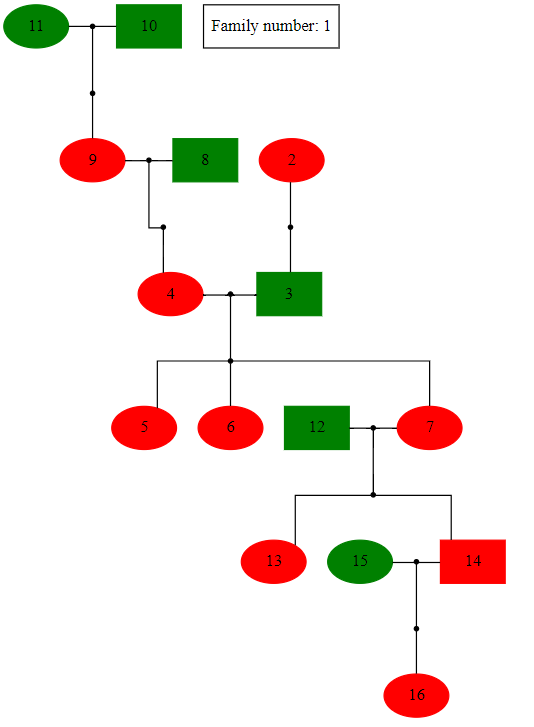
